In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ptitprince as pt
import matplotlib.pyplot as plt

In [20]:
def read_dataframe(path):
    df = pd.read_parquet(path)
    df["duration_min"] = (df["dropOff_datetime"] - df["pickup_datetime"]) / (np.timedelta64(1, 's') * 60)
    df = df[(df["duration_min"] >= 1) & (df["duration_min"] <= 60)]
    
    df["PUlocationID"].fillna(-1, inplace=True)
    df["DOlocationID"].fillna(-1, inplace=True) 
    
    categorical = ['PUlocationID', 'DOlocationID']
    df[categorical] = df[categorical].astype(str)
    return df

## Q1. Downloading the data

Read the data for January. How many records are there?

In [3]:
df = pd.read_parquet("../data/fhv_tripdata_2021-01.parquet")
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


There are 1154112 rows.

## Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

In [4]:
df.head(2)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009


In [5]:
df["duration_min"] = (df["dropOff_datetime"] - df["pickup_datetime"]) / (np.timedelta64(1, 's') * 60)

In [6]:
f"Average trip duration in January is {df['duration_min'].mean()}"

'Average trip duration in January is 19.167224093791006'

## Data preparation
Check the distribution of the duration variable. There are some outliners.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

<AxesSubplot:xlabel='duration_min'>

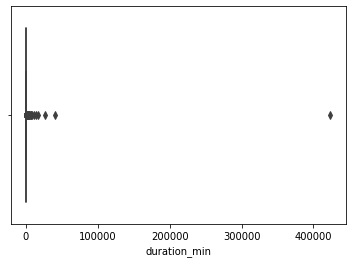

In [7]:
sns.boxplot(x=df["duration_min"])

<AxesSubplot:xlabel='duration_min'>

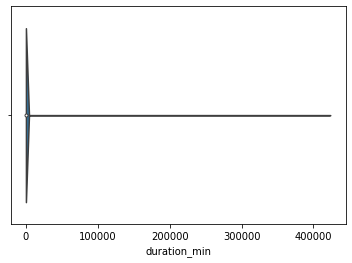

In [8]:
sns.violinplot(x=df["duration_min"])

In [9]:
ort="v"; pal = sns.color_palette(n_colors=1); sigma = 0.8

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


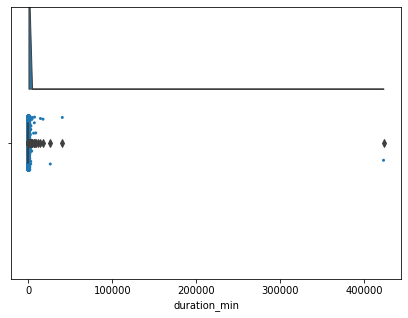

In [10]:
f, ax = plt.subplots(figsize=(7, 5))
ax=pt.RainCloud(x=df["duration_min"], palette = pal, bw = sigma,
                 width_viol = .9, ax = ax)

In [11]:
df_no_outliers = df[(df["duration_min"] >= 1) & (df["duration_min"] <= 60)]

In [12]:
f"{len(df) - len(df_no_outliers)} records were dropped"

'44286 records were dropped'

## Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1"

What's the factions of missing values for the pickup location ID? (Or the fraction of "-1"s after you filled the NAs)

In [13]:
df.columns

Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number',
       'duration_min'],
      dtype='object')

<AxesSubplot:>

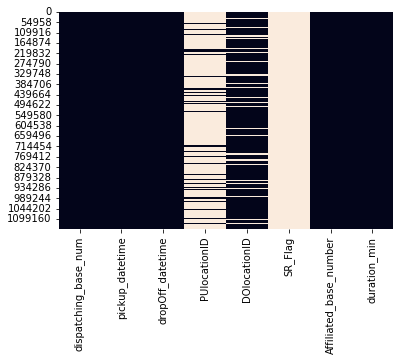

In [14]:
sns.heatmap(df.isnull(), cbar=False)

In [15]:
f'Fraction of missing values of pickup location id is: {(df["PUlocationID"].isnull().sum() / len(df)) * 100}'

'Fraction of missing values of pickup location id is: 83.03067639882438'

In [18]:
(df["DOlocationID"].isnull().sum() / len(df)) * 100

14.0558282038485

In [19]:
df["PUlocationID"].fillna(-1, inplace=True) 
df["DOlocationID"].fillna(-1, inplace=True) 

## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns)

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

Convert into categorical variables before encoding.

In [22]:
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)

In [23]:
v = DictVectorizer(sparse=False)

In [24]:
list_of_dicts = df[["PUlocationID", "DOlocationID"]].to_dict("records")

In [25]:
X = v.fit_transform(list_of_dicts)

In [26]:
X.shape

(1154112, 525)

Alternative way of doing it with pandas `get_dummies` method.

In [27]:
df_one_hot = pd.get_dummies(df[["PUlocationID", "DOlocationID"]])

In [28]:
f'Numbers of columns in feature matrix is: {df_one_hot.values.shape[1]}'

'Numbers of columns in feature matrix is: 525'

525 columns

## Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [30]:
df_train = read_dataframe("../data/fhv_tripdata_2021-01.parquet")
df_val = read_dataframe("../data/fhv_tripdata_2021-02.parquet")

In [31]:
X_train = pd.get_dummies(df_train[["PUlocationID", "DOlocationID"]]).values
#X_train = dv.fit_transform(train_dicts)

X_val = pd.get_dummies(df_val[["PUlocationID", "DOlocationID"]]).values
#X_val = dv.fit_transform(val_dicts)

In [32]:
target = "duration_min"
y_train = df_train[target].values
y_val = df_val[target].values

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.528519107168236

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

If I try to do it just as it is, I got an error because feature matrix dimensions are different between training and validation sets.

```
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)
```

Exploring a little bit, I found that there is one value in `DOlocationID` in validation set that is not present in training set, with 3 observations.

In [34]:
unique_train = np.concatenate([df_train["DOlocationID"].unique(), df_train["PUlocationID"].unique()])

In [35]:
unique_val = np.concatenate([df_val["DOlocationID"].unique(), df_val["PUlocationID"].unique()])

In [36]:
set_A = set(df_train["DOlocationID"].unique())
set_B = set(df_val["DOlocationID"].unique())

In [37]:
print(len(df_train["DOlocationID"].unique()), len(df_val["DOlocationID"].unique()))

263 264


In [38]:
set_B.difference(set_A)

{'110.0'}

In [39]:
set_A = set(df_train["PUlocationID"].unique())
set_B = set(df_val["PUlocationID"].unique())

In [40]:
set_A.difference(set_B)

set()

In [41]:
df_val[df_val["DOlocationID"] == "110.0"]

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration_min
144951,B03060,2021-02-05 13:18:45,2021-02-05 13:58:48,-1.0,110.0,None,B03060,40.050000
891678,B00972,2021-02-25 06:51:37,2021-02-25 06:54:21,176.0,110.0,None,B00972,2.733333
892044,B01452,2021-02-25 06:51:37,2021-02-25 06:54:21,176.0,110.0,None,B01452,2.733333


So, to solve this issue, I dropped the value to match the dimensions

In [43]:
df_val_fix = df_val[df_val["DOlocationID"] != "110.0"]

In [44]:
X_val_fix = pd.get_dummies(df_val_fix[["PUlocationID", "DOlocationID"]]).values
y_val_fix = df_val_fix[target].values

In [45]:
X_val_fix.shape, y_val_fix.shape

((990110, 525), (990110,))

In [46]:
y_pred = lr.predict(X_val_fix)

mean_squared_error(y_val_fix, y_pred, squared=False)

11.01425378462221